In [1]:
import datetime
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from collections import defaultdict

In [2]:
spy_df = yf.Ticker('SPY').history(period="max")

In [3]:
spy_df['Returns'] = np.nan
spy_df['Returns'].values[1:] = (spy_df['Close'].values[1:] - spy_df['Close'].values[:-1])/spy_df['Close'].values[:-1]
spy_df['LOGRET_1'] = spy_df.ta.log_return()

<AxesSubplot:xlabel='Date'>

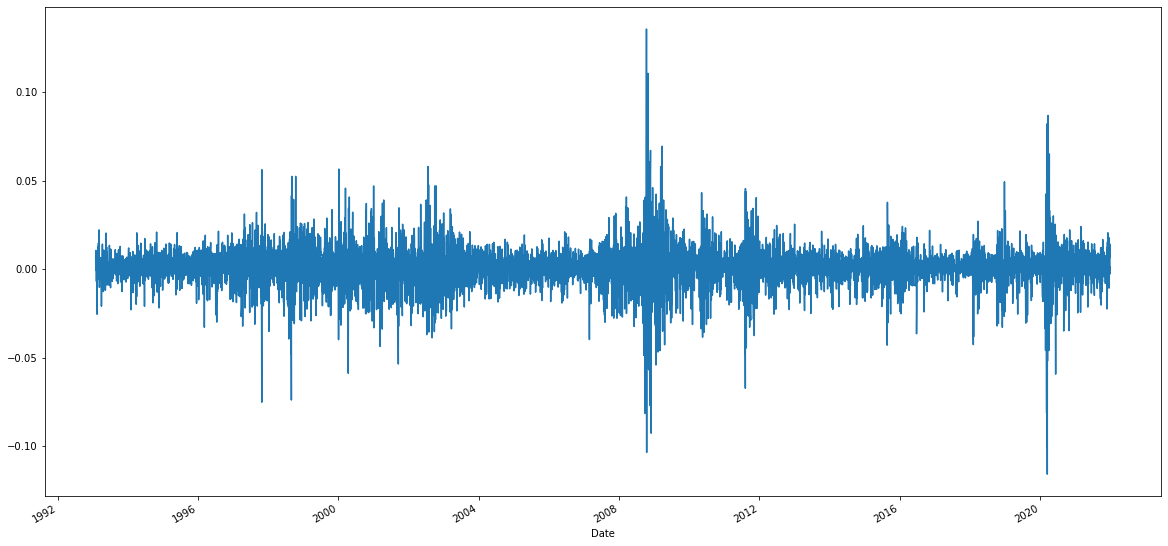

In [4]:
spy_df['LOGRET_1'].plot(figsize=(20,10))

# Algorithm 1: WK-means algorithm
### Result: k centroids
### calculate l(rS ) given S;
### define family of empirical distributions K = {μj }1≤j≤M ;
### initialise centroids μi, i = 1, . . . , k by sampling k times from K;
### while loss_function > tolerance do
### ____for each μj do
### ________assign closest centroid wrt Wp to cluster Cl, l = 1, . . . , k;
### ____end
### ____update centroid i as the Wasserstein barycenter relative to Cl;
### ____calculate loss_function;
### end

# What is S?

S is log-returns

### I believe their formula for M:"maximum number of partitions with length h1 that can be extracted from x with sliding window offset parameter h2" is incorrect. Giving priority to newer data by truncating earlier data, I calculated M to be:
## M = 1+((N-h1+1) - ((N-h1)%h2)-1)//h2

In [9]:
N = spy_df.shape[0] - 1
h2 = np.random.randint(1, 25)
h1 = np.random.randint(h2, 100)
count = 0
for s_idx in np.arange((N-h1)%h2, N-h1+1, h2):
    e_idx = s_idx + h1
    count += 1
print(count, s_idx, e_idx)
assert count == 1+((N-h1+1) - ((N-h1)%h2)-1)/h2

425 7222 7284


In [10]:
def lift(r_S, h1, h2):
    N = r_S.shape[0]-1 # truncates NaN at start of series
    out = np.zeros((1+((N-h1+1) - ((N-h1)%h2)-1)//h2, h1), dtype=np.float32)
    for idx, s_idx in enumerate(np.arange((N-h1)%h2, N-h1+1, h2)):
        e_idx = s_idx + h1
        out[idx] = r_S[s_idx+1:e_idx+1]
    return out

### The lift on S(X) is segments of length h1 of with consecutive segments in the sequence overlapping by h2 elements.

In [11]:
h1 = 21
h2 = 5
l_r_S = lift(spy_df['LOGRET_1'].values[1:], h1, h2)
assert np.isclose(l_r_S[-1, -1],  spy_df['LOGRET_1'].values[-1]) # float64 -> float32
print(l_r_S.shape)

(1453, 21)


### 1% and 99% log return percentile values

In [12]:
min_ = np.percentile(spy_df['LOGRET_1'].values[((N-h1)%h2)+1:], 1)
max_ = np.percentile(spy_df['LOGRET_1'].values[((N-h1)%h2)+1:], 99)
n_bins = 25
bins_ = np.linspace(min_, max_, n_bins).reshape(1, n_bins)
min_, max_

(-0.0328703048054517, 0.03240154197838105)

In [13]:
def extract_percentiles(r_S, h1, h2, lp=1, up=99):
    N = r_S.shape[0]-1
    min_ = np.percentile(r_S[((N-h1)%h2)+1:], 1)
    max_ = np.percentile(r_S[((N-h1)%h2)+1:], 99)
    return min_, max_ 
min_, max_ = extract_percentiles(spy_df['LOGRET_1'].values, h1, h2, lp=1, up=99)
print(min_, max_)
n_bins = 25
bins_ = np.linspace(min_, max_, n_bins).reshape(1, n_bins)

-0.0328703048054517 0.03240154197838105


### Plotting some sample empirical CDFs

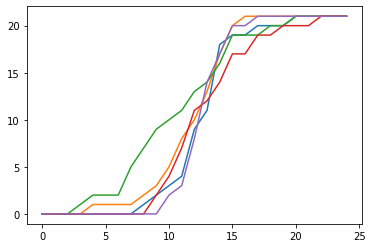

In [16]:
import matplotlib.pyplot as plt
plt.plot((l_r_S[11].reshape(h1, 1) < bins_).sum(0))
plt.plot((l_r_S[50].reshape(h1, 1) < bins_).sum(0))
plt.plot((l_r_S[500].reshape(h1, 1) < bins_).sum(0))
plt.plot((l_r_S[1000].reshape(h1, 1) < bins_).sum(0))
plt.plot((l_r_S[1200].reshape(h1, 1) < bins_).sum(0))

In [43]:
def extract_empirical_measures(l_r_S, bins, h1):
    l_r_S = l_r_S.reshape(l_r_S.shape[0], l_r_S.shape[1], 1)
    K = np.zeros((l_r_S.shape[0], bins.shape[1]))
    for idx in np.arange(l_r_S.shape[0]):
        K[idx] = (l_r_S[idx] < bins).sum(0)
    return K/h1

### Plotting Histogram of first and last bins of empirical CDFs

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    3.,    5.,    4.,    6.,
          12.,   45., 1378.]),
 array([0.        , 0.04761905, 0.0952381 , 0.14285714, 0.19047619,
        0.23809524, 0.28571429, 0.33333333, 0.38095238, 0.42857143,
        0.47619048, 0.52380952, 0.57142857, 0.61904762, 0.66666667,
        0.71428571, 0.76190476, 0.80952381, 0.85714286, 0.9047619 ,
        0.95238095, 1.        ]),
 <BarContainer object of 21 artists>)

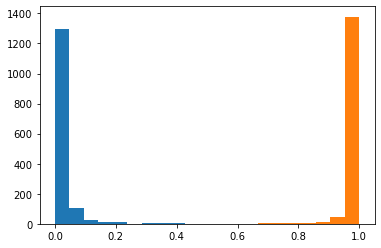

In [56]:
K = extract_empirical_measures(l_r_S, bins_, h1)
plt.hist(K[:, 0], bins=np.arange(h1+1)/h1)
plt.hist(K[:, n_bins-1], bins=np.arange(h1+1)/h1)

### Coordinate-wise standardisation

In [65]:
# from copy import deepcopy
# stdd_K = deepcopy(K)
# stdd_K -= stdd_K.mean(0)
# stdd_K /= stdd_K.std(0)
# assert np.isclose(stdd_K.mean(0), 0).all()
# assert np.isclose(stdd_K.var(0), 1).all()

In [73]:
from copy import deepcopy
stdd_K = deepcopy(K)
stdd_K -= stdd_K.mean(1).reshape(-1, 1)
stdd_K /= stdd_K.std(1).reshape(-1, 1)
assert np.isclose(stdd_K.mean(1), 0).all()
assert np.isclose(stdd_K.var(1), 1).all()

### Plotting some sample coordinate-wise standardised empirical CDFs

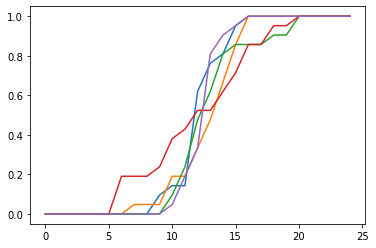

In [108]:
plt.plot(K[np.random.randint(K.shape[0])])
plt.plot(K[np.random.randint(K.shape[0])])
plt.plot(K[np.random.randint(K.shape[0])])
plt.plot(K[np.random.randint(K.shape[0])])
plt.plot(K[np.random.randint(K.shape[0])])

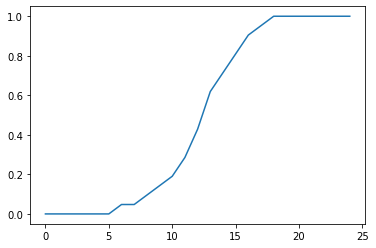

In [109]:
plt.plot(np.median(K, 0))

In [110]:
np.abs(K[0] - K[1]).sum()/n_bins

0.01904761904761906

In [115]:
l_r_S[0]

array([ 0.00417557, -0.00069489,  0.        , -0.00697338,  0.00139872,
        0.00487936, -0.00767898, -0.02555073, -0.00071938, -0.00071967,
        0.00359287,  0.00358053, -0.00071489,  0.01279367,  0.00211569,
        0.00140864, -0.0028189 ,  0.01471113,  0.00416384, -0.00555545,
       -0.00278868], dtype=float32)

In [274]:
def calc_wasserstein_barycenter(K_ss):
    n_bins = K_ss.shape[1]
    a = np.median(K_ss, 0)
    bins = np.linspace(0, 1, n_bins)
    u_hat = ((a.reshape(n_bins, 1) >= (np.linspace(0, 1, n_bins)).reshape(1,-1)).sum(1))/n_bins
    return u_hat
    

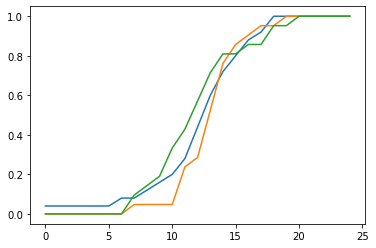

In [236]:
a = np.median(K, 0)
u_hat = ((a.reshape(n_bins, 1) >= (np.linspace(0, 1, n_bins)).reshape(1,-1)).sum(1))/n_bins
plt.plot(u_hat)
plt.plot(K[np.random.randint(K.shape[0])])
plt.plot(K[np.random.randint(K.shape[0])])

(array([ 15.,  42., 245., 169., 933.,  49.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

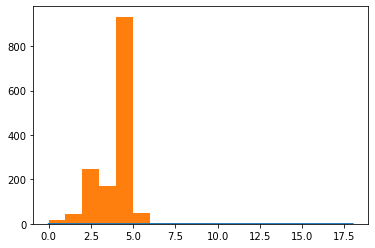

In [300]:
L = []
k = 6
delta = 1*10**-7
centroids = K[np.random.choice(np.arange(K.shape[0]), size=k, replace=False)]
cluster_assigns = np.zeros(K.shape[0])
for idx, uj in enumerate(K):
    cluster_assigns[idx] = np.argmin(np.abs(uj - centroids).sum(1)/n_bins)
centroids_new = np.stack([calc_wasserstein_barycenter(K[cluster_assigns==c]) for c in range(k)])
loss = np.sum(np.abs(centroids_new - centroids).sum(1)/n_bins)
L.append(loss)    
for itrn in range(100):
    centroids = centroids_new
    cluster_assigns = np.zeros(K.shape[0])
    for idx, uj in enumerate(K):
        cluster_assigns[idx] = np.argmin(np.abs(uj - centroids).sum(1)/n_bins)
    centroids_new = np.stack([calc_wasserstein_barycenter(K[cluster_assigns==c]) for c in range(k)])
    loss = np.sum(np.abs(centroids_new - centroids).sum(1)/n_bins)
    L.append(loss)
    if loss < delta:
        break
plt.hist(cluster_assigns, bins = np.arange(0, k+1))

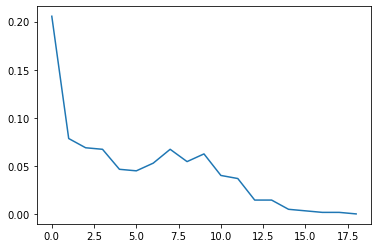

In [301]:
plt.plot(L)

# WK-means Algorithm

(array([1157.,  296.]), array([0, 1, 2]), <BarContainer object of 2 artists>)

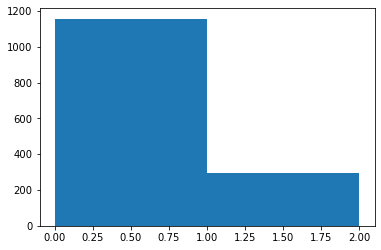

In [320]:
L = []
k = 2
delta = 1*10**-7
centroids = K[np.random.choice(np.arange(K.shape[0]), size=k, replace=False)]
cluster_assigns = np.zeros(K.shape[0])
for idx, uj in enumerate(K):
    cluster_assigns[idx] = np.argmin(np.abs(uj - centroids).sum(1)/n_bins)
centroids_new = np.stack([calc_wasserstein_barycenter(K[cluster_assigns==c]) for c in range(k)])
loss = np.sum(np.abs(centroids_new - centroids).sum(1)/n_bins)
L.append(loss)    
for itrn in range(100):
    centroids = centroids_new
    cluster_assigns = np.zeros(K.shape[0])
    for idx, uj in enumerate(K):
        cluster_assigns[idx] = np.argmin(np.abs(uj - centroids).sum(1)/n_bins)
    centroids_new = np.stack([calc_wasserstein_barycenter(K[cluster_assigns==c]) for c in range(k)])
    loss = np.sum(np.abs(centroids_new - centroids).sum(1)/n_bins)
    L.append(loss)
    if loss < delta:
        break
plt.hist(cluster_assigns, bins = np.arange(0, k+1))

## Loss plot

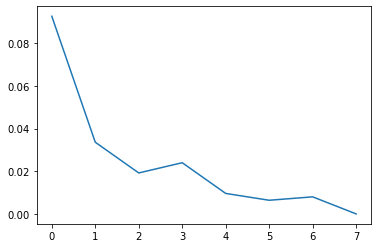

In [321]:
plt.plot(L)

In [322]:
np.ones_like((l_r_S)) * cluster_assigns.reshape(-1,1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [370]:
from math import ceil
def delift(labels, r_S, h1, h2):
    N = r_S.shape[0]-1 # truncates NaN at start of series
    # out = np.zeros((1+((N-h1+1) - ((N-h1)%h2)-1)//h2, h1), dtype=np.float32)
    n_labels = ceil(h1/h2)
    out = np.zeros((N+1, n_labels)) * np.nan
    label_id = 0
    for idx, s_idx in enumerate(np.arange((N-h1)%h2, N-h1+1, h2)):
        e_idx = s_idx + h1
        out[s_idx+1:e_idx+1, label_id] = labels[idx]
        label_id = (label_id+1)%n_labels
    return out

In [371]:
md_label = delift(cluster_assigns, spy_df['LOGRET_1'].values, h1, h2)
mu_label = np.nanmean(md_label, 1)

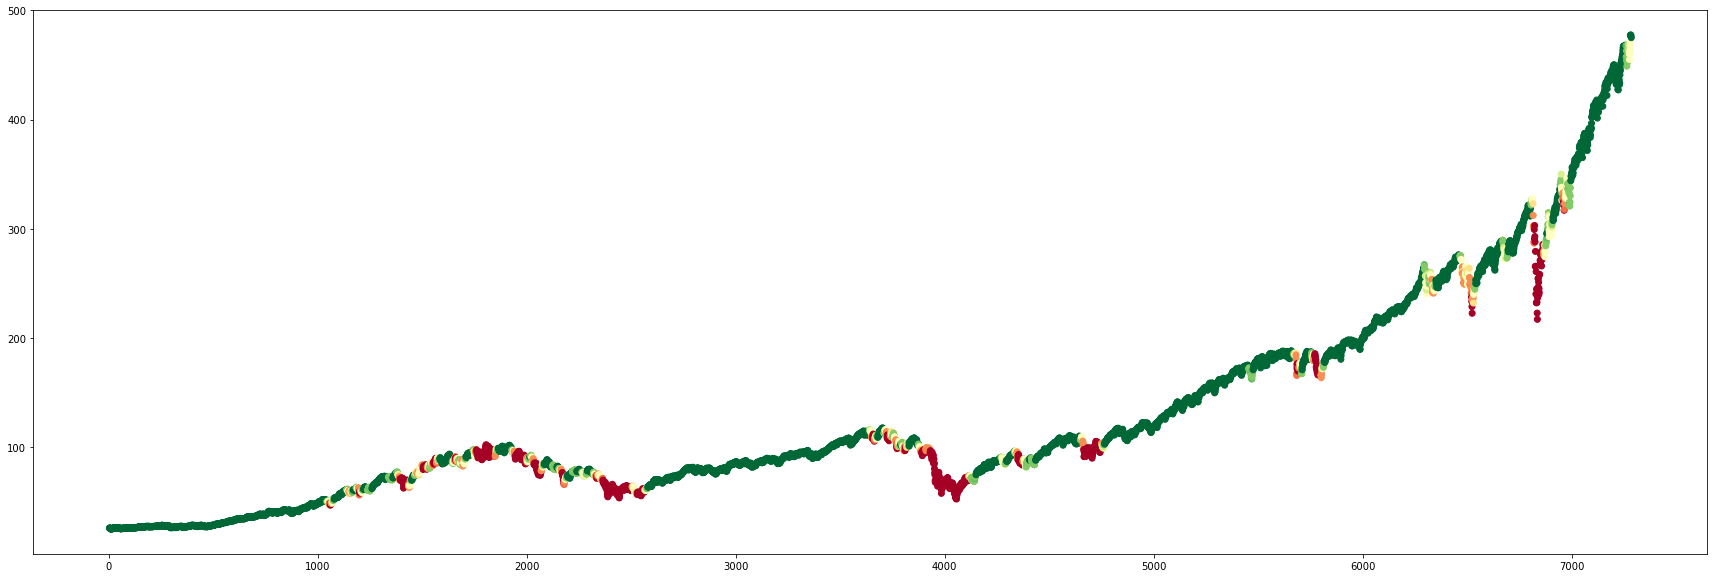

In [425]:
fig = plt.figure(figsize=(30,10))
plt.scatter(X, Y, c=1-mu_label, cmap='RdYlGn')